<a href="https://colab.research.google.com/github/Anaum-Khan/Flood-Prediction-Using-Satellite-Imaging/blob/main/RESNET_with_final_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA PREPROCESSING**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
data = pd.read_csv('/content/final-data.csv')
print("Initial Data Shape:", data.shape)
print("Initial Missing Values:\n", data.isnull().sum())


Initial Data Shape: (1948, 7)
Initial Missing Values:
 time                           0
temperature_2m (°C)            0
relative_humidity_2m (%)       0
rain (mm)                      0
Dam activity                1948
cloud_cover_low (%)            0
wind_speed_10m (km/h)          0
dtype: int64


In [ ]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
print("Data Shape After Filling:", data.shape)
print("Number of Missing Values After Filling:\n", data.isnull().sum())


Data Shape After Filling: (1948, 7)
Number of Missing Values After Filling:
 time                           0
temperature_2m (°C)            0
relative_humidity_2m (%)       0
rain (mm)                      0
Dam activity                1948
cloud_cover_low (%)            0
wind_speed_10m (km/h)          0
dtype: int64


In [ ]:
print("Data After Filling Missing Values:\n", data.head())


Data After Filling Missing Values:
                time  temperature_2m (°C)  relative_humidity_2m (%)  rain (mm)  \
0  2021-06-01T00:00                 28.0                        88        0.0   
1  2021-06-01T06:00                 33.7                        59        0.0   
2  2021-06-01T12:00                 29.6                        78        0.0   
3  2021-06-01T18:00                 26.9                        95        0.0   
4  2021-06-02T00:00                 25.5                        97        0.0   

   Dam activity  cloud_cover_low (%)  wind_speed_10m (km/h)  
0           NaN                    0                   12.2  
1           NaN                    0                    1.9  
2           NaN                    0                   15.2  
3           NaN                    0                    4.6  
4           NaN                   46                    6.6  


In [ ]:
X = data.drop(columns=['rain (mm)'])  # 'rain (mm)' is target variable
y = data['rain (mm)']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Separate 'time' column into 'date' and 'hour'
X_train['date'] = pd.to_datetime(X_train['time']).dt.date
X_train['hour'] = pd.to_datetime(X_train['time']).dt.hour

# Drop the original 'time' column
X_train = X_train.drop(columns=['time', 'Dam activity'])

# Now repeat the same for X_test if it has a 'time' column
X_test['date'] = pd.to_datetime(X_test['time']).dt.date
X_test['hour'] = pd.to_datetime(X_test['time']).dt.hour
X_test = X_test.drop(columns=['time', 'Dam activity'])


In [ ]:
# Display rows of X_train and X_test
print("X_train after modifications:")
print(X_train.head())

print("\nX_test after modifications:")
print(X_test.head())

X_train after modifications:
      temperature_2m (°C)  relative_humidity_2m (%)  cloud_cover_low (%)  \
862                  15.9                        82                    0   
534                  29.5                        71                    6   
1693                 31.1                        69                  100   
1425                 34.8                        45                    0   
925                  15.6                        65                    0   

      wind_speed_10m (km/h)        date  hour  
862                     8.8  2022-01-02    12  
534                     5.9  2021-10-12    12  
1693                    7.4  2022-07-29     6  
1425                   13.6  2022-05-23     6  
925                    12.1  2022-01-18     6  

X_test after modifications:
      temperature_2m (°C)  relative_humidity_2m (%)  cloud_cover_low (%)  \
1613                 34.2                        58                    7   
1404                 29.1                    

In [ ]:
# Check data types to confirm only numeric columns are being scaled
print("\nData types in X_train after modifications:")
print(X_train.dtypes)

print("\nData types in X_test after modifications:")
print(X_test.dtypes)


Data types in X_train after modifications:
temperature_2m (°C)         float64
relative_humidity_2m (%)      int64
cloud_cover_low (%)           int64
wind_speed_10m (km/h)       float64
date                         object
hour                          int32
dtype: object

Data types in X_test after modifications:
temperature_2m (°C)         float64
relative_humidity_2m (%)      int64
cloud_cover_low (%)           int64
wind_speed_10m (km/h)       float64
date                         object
hour                          int32
dtype: object


In [ ]:
# Scale the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_test = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))

In [ ]:
# Check the statistical summary to confirm that scaling was applied (mean should be close to 0, std close to 1)

print("\nMean of each feature in scaled X_train (should be close to 0):")
print(np.mean(X_train, axis=0))

print("\nStandard deviation of each feature in scaled X_train (should be close to 1):")
print(np.std(X_train, axis=0))


Mean of each feature in scaled X_train (should be close to 0):
[-3.64848645e-17  1.44799306e-16 -5.47272967e-17  3.11546538e-16]

Standard deviation of each feature in scaled X_train (should be close to 1):
[1. 1. 1. 1.]


# **RESNET MODEL SETUP**

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


In [ ]:
# Reshape your input to 32x32x3 by tiling or padding, making it compatible with ResNet-50
X_train_resized = np.repeat(X_train[:, :, np.newaxis], 3, axis=2).reshape(-1, 2, 2, 3)
X_train_resized = np.tile(X_train_resized, (1, 16, 16, 1))  # Now shape is (32, 32, 3)

X_test_resized = np.repeat(X_test[:, :, np.newaxis], 3, axis=2).reshape(-1, 2, 2, 3)
X_test_resized = np.tile(X_test_resized, (1, 16, 16, 1))  # Now shape is (32, 32, 3)



In [ ]:
# Load and build the ResNet-50 model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(32, 32, 3),  # Updated shape
    weights='imagenet'
)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze base model and add custom layers for regression
from tensorflow.keras import models, layers

base_model.trainable = False
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])



In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# Train the model
history = model.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=50,
    batch_size=32
)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 319ms/step - loss: 23.6986 - mae: 2.7278 - val_loss: 6.0875e-04 - val_mae: 0.0243
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - loss: 0.0066 - mae: 0.0640 - val_loss: 1.4359e-04 - val_mae: 0.0111
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - loss: 5.4997e-05 - mae: 0.0059 - val_loss: 1.9962e-05 - val_mae: 0.0037
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - loss: 1.9982e-05 - mae: 0.0035 - val_loss: 1.7875e-05 - val_mae: 0.0035
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - loss: 1.8450e-05 - mae: 0.0034 - val_loss: 1.4301e-05 - val_mae: 0.0030
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - loss: 1.2531e-05 - mae: 0.0028 - val_loss: 7.1957e-06 - val_mae: 0.0022
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - loss: 9.8609e-06 - mae: 0.0024 - val_loss: 5.8047e-06 - val_mae: 0.0020
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 296ms/step - loss: 6.1609e-06 - mae: 0.0020 - val_loss: 5.1959e-06 - val_mae

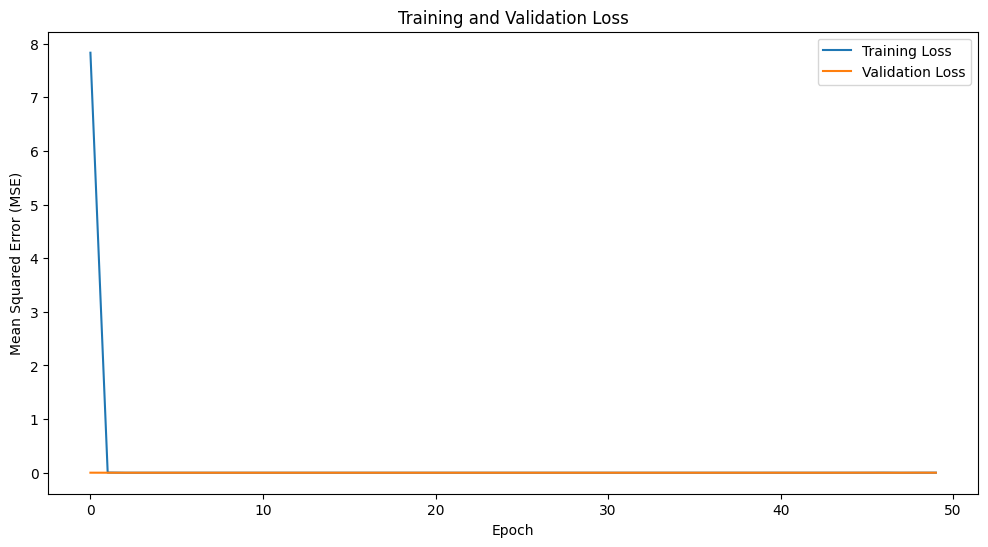

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Make predictions
predictions = model.predict(X_test_resized)

# Display the first few predictions alongside actual values
for i in range(10):
    print(f"Predicted: {predictions[i][0]:.2f}, Actual: {y_test[i]}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]
Predicted: 0.02, Actual: [0]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calculate MAE, MAPE, and R-squared
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-squared (R²): {r2:.2f}")


Mean Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 10314629910330552.00%
R-squared (R²): 0.00


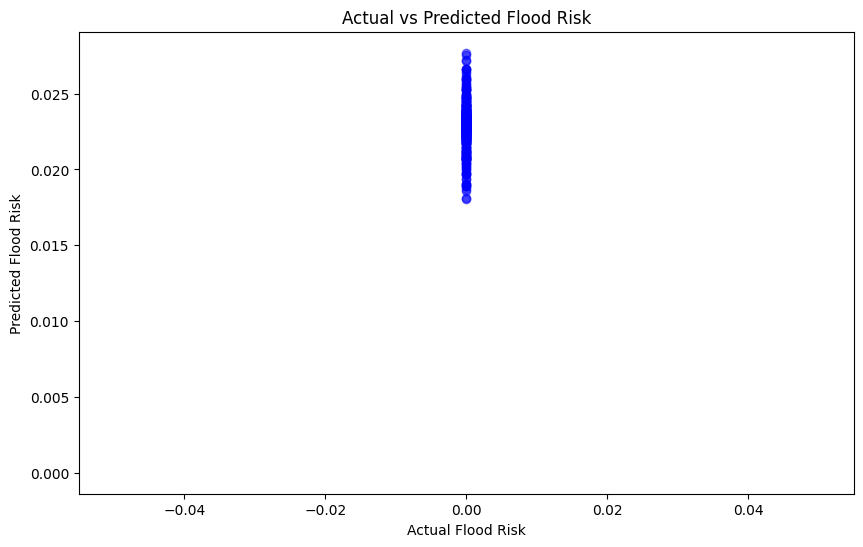

In [ ]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal 1:1 line
plt.xlabel('Actual Flood Risk')
plt.ylabel('Predicted Flood Risk')
plt.title('Actual vs Predicted Flood Risk')
plt.show()


# **OPTION 2: SIMPLIFIED NETWORK**

In [ ]:
from tensorflow.keras import models, layers


In [ ]:
# Flatten the data and use a simpler model structure
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=32
)


Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.6850 - mae: 1.2708 - val_loss: 38.3472 - val_mae: 1.9645
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2448 - mae: 1.4964 - val_loss: 37.0853 - val_mae: 1.7673
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5037 - mae: 1.3709 - val_loss: 37.5732 - val_mae: 1.6611
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4759 - mae: 1.2896 - val_loss: 36.4557 - val_mae: 1.7454
Epoch 5/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1001 - mae: 1.1885 - val_loss: 36.7826 - val_mae: 1.6691
Epoch 6/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4785 - mae: 1.3205 - val_loss: 36.3631 - val_mae: 1.6982
Epoch 7/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2917 - mae: 1.2146 - val_loss: 36.6006 - val_mae: 1.6886
Epoch 8/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6936 - mae: 1.2549 - val_loss: 35.3866 - val_mae: 1.8340
Epoch 9/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.7917 - mae: 1.7823
Test Loss: 39.251155853271484, Test MAE: 1.8965510129928589


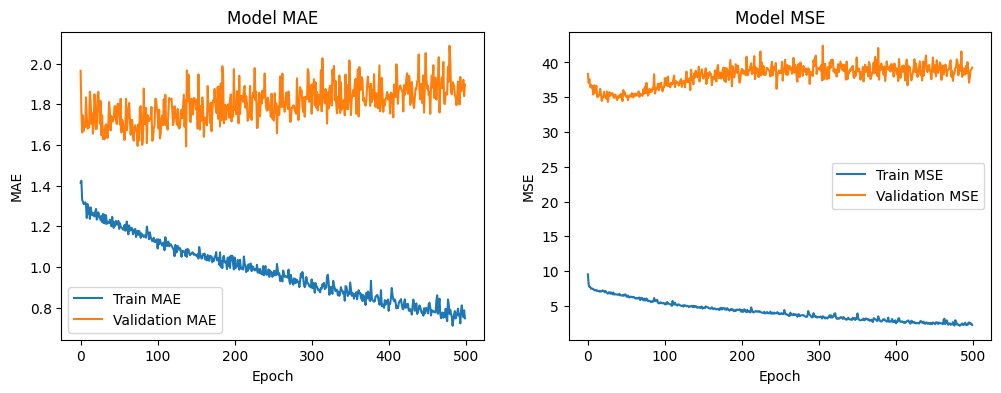

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()


In [ ]:
# Example threshold, assuming rainfall is in the first column of X_train
flood_threshold = 50  # mm of rainfall; adjust based on your data specifics

# Generate binary labels: 1 if rainfall >= threshold, else 0
y_train = (X_train[:, 0] >= flood_threshold).astype(int)
y_test = (X_test[:, 0] >= flood_threshold).astype(int)


In [ ]:
# Predict flood probabilities
flood_probabilities = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
flood_predictions = (flood_probabilities >= 0.5).astype(int)

# Show predictions with probabilities for first few samples
for i in range(10):
    print(f"Predicted Probability: {flood_probabilities[i][0]:.2f}, Predicted Label: {flood_predictions[i][0]}, Actual Label: {y_test[i]}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted Probability: 0.09, Predicted Label: 0, Actual Label: [0]
Predicted Probability: 0.31, Predicted Label: 0, Actual Label: [0]
Predicted Probability: -0.04, Predicted Label: 0, Actual Label: [0]
Predicted Probability: -0.00, Predicted Label: 0, Actual Label: [0]
Predicted Probability: 1.47, Predicted Label: 1, Actual Label: [0]
Predicted Probability: 9.71, Predicted Label: 1, Actual Label: [0]
Predicted Probability: 0.04, Predicted Label: 0, Actual Label: [0]
Predicted Probability: -0.01, Predicted Label: 0, Actual Label: [0]
Predicted Probability: -0.18, Predicted Label: 0, Actual Label: [0]
Predicted Probability: 1.63, Predicted Label: 1, Actual Label: [0]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert flood_probabilities to binary predictions
flood_predictions = (flood_probabilities >= 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_test, flood_predictions)
precision = precision_score(y_test, flood_predictions)
recall = recall_score(y_test, flood_predictions)
f1 = f1_score(y_test, flood_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.63
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


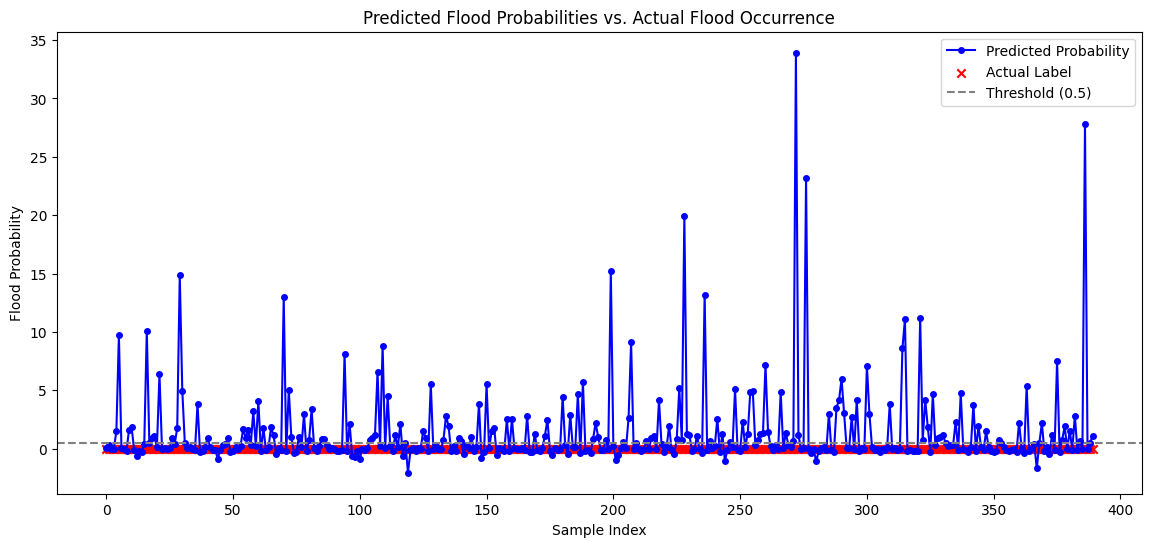

In [ ]:
# Plot predicted probabilities and actual labels
plt.figure(figsize=(14, 6))

# Plot flood probabilities
plt.plot(flood_probabilities, label='Predicted Probability', color='b', marker='o', linestyle='-', markersize=4)
# Plot actual labels (use scatter to show discrete 0 or 1 values)
plt.scatter(range(len(y_test)), y_test, color='r', label='Actual Label', marker='x')

# Add threshold line at 0.5 for reference
plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold (0.5)')

# Add labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Flood Probability')
plt.title('Predicted Flood Probabilities vs. Actual Flood Occurrence')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Calculate MAPE and R-squared
mape = mean_absolute_percentage_error(y_test, flood_probabilities)
r2 = r2_score(y_test, flood_probabilities)

print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"R-squared (R²): {r2:.2f}")


Mean Absolute Percentage Error (MAPE): 685603746093230336.00%
R-squared (R²): 0.00
